In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt

from training.manifolds import SO3
from training.metric import so3_mmd
from training.sampling import flow_sample, consistency_sample
from datasets.so3_dataset import RotationDataset, RawDataset

In [3]:
def apply_rotvec(x, rotvec):
    theta = torch.norm(rotvec, dim=-1, p=2, keepdim=True)
    sin, cos = torch.sin(theta), torch.cos(theta)
    axis = rotvec / theta.clamp(min=1e-4)
    ad = torch.cross(axis, x, dim=-1)
    ad2 = torch.cross(axis, ad, dim=-1)
    return x + sin * ad + (1 - cos) * ad2

def plot_rots(R_samples):
    """Plot a series of rotations as if they have been applied to the coordinate frame."""
    x_axis, y_axis, z_axis = torch.eye(3, dtype=torch.float).unsqueeze(1)
    x_rotated = apply_rotvec(x_axis, R_samples).numpy()
    y_rotated = apply_rotvec(y_axis, R_samples).numpy()
    z_rotated = apply_rotvec(z_axis, R_samples).numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='w', alpha=0.3)

    ax.quiver(0, 0, 0, 1, 0, 0, color='black', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1, 0, color='black', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1, color='black', arrow_length_ratio=0.1)
    ax.text(1.1, 0, 0, 'X', color='black')
    ax.text(0, 1.1, 0, 'Y', color='black')
    ax.text(0, 0, 1.1, 'Z', color='black')

    ax.scatter(x_rotated[:, 0], x_rotated[:, 1], x_rotated[:, 2], color='red', s=10, label='x-axis rotated', alpha=0.1)
    ax.scatter(y_rotated[:, 0], y_rotated[:, 1], y_rotated[:, 2], color='green', s=10, label='y-axis rotated', alpha=0.1)
    ax.scatter(z_rotated[:, 0], z_rotated[:, 1], z_rotated[:, 2], color='blue', s=10, label='z-axis rotated', alpha=0.1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=20., azim=50, roll=0)

    ax.legend()
    plt.show()

Data size: torch.Size([10000, 1, 3])


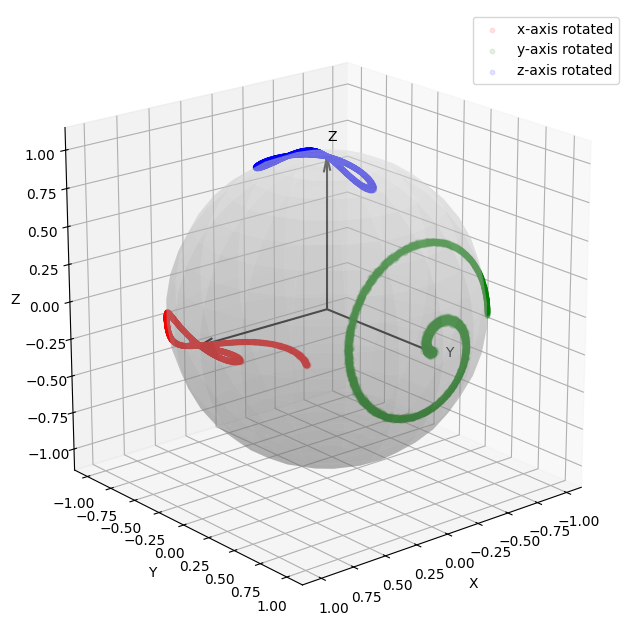

In [4]:
dataset = RotationDataset(10000, 0.1, 10)
# dataset = RawDataset('data/so3', 'cone', max_sample=10000)  # Or fisher24, line, peak
print(f'Data size:', dataset.data.size())
plot_rots(dataset.data.squeeze(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 140.04it/s]


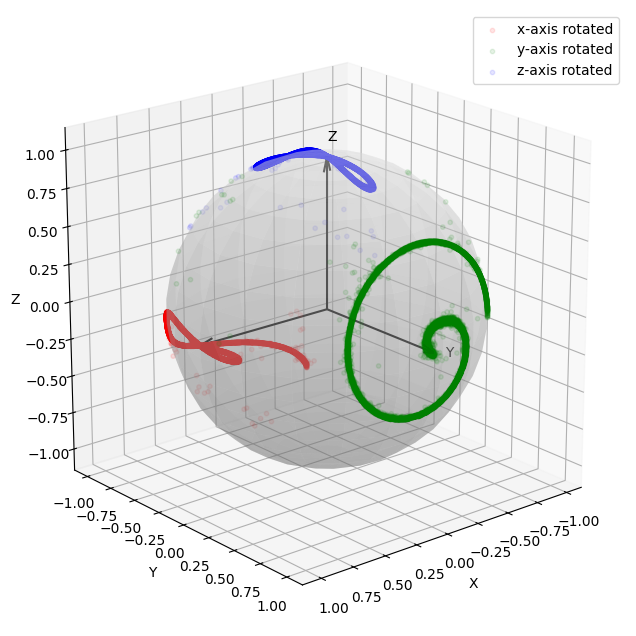

In [5]:
device = 'cuda:0'
ckpt_path = '../training-runs/000010-Rotation-flow-gpus1-batch512/network-snapshot-050000.pkl'
n_steps = 100
with open(ckpt_path, 'rb') as f:
    rfm = pickle.load(f)['ema']
rfm.eval()
with torch.no_grad():
    rfm_samples = flow_sample(rfm, SO3(3), n_sample=len(dataset), n_steps=n_steps, device=device).squeeze(1)
plot_rots(rfm_samples.cpu())

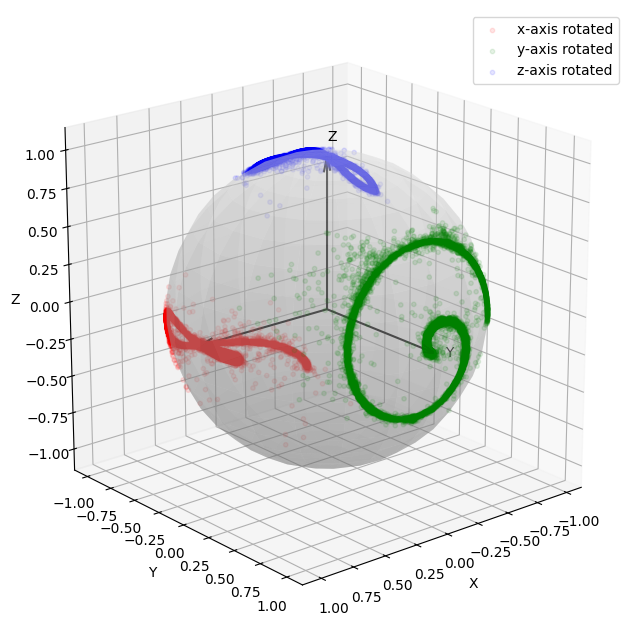

In [ ]:
# Note that on such small datasets, RCD models can overfit quite early. An earlier checkpoint may be better in terms of MMD.
device = 'cuda:0'
ckpt_path = '../consis-training-runs-so3/000010-Rotation-Continuous-consistency-gpus1-batch512/network-snapshot-028134.pkl'
with open(ckpt_path, 'rb') as f:
    rcd = pickle.load(f)['ema']
rcd.eval()
with torch.no_grad():
    rcd_samples = consistency_sample(rcd, SO3(3), n_sample=len(dataset), n_steps=2, device=device).squeeze(1)
plot_rots(rcd_samples.cpu())

In [ ]:
rfm_mmd = so3_mmd(dataset.data.squeeze(1).to(device), rfm_samples, 1)
rcd_mmd = so3_mmd(dataset.data.squeeze(1).to(device), rcd_samples, 1)
print(f'RFM-100 MMD: {rfm_mmd:.5f}, RCD-2 MMD: {rcd_mmd:.5f}')

RFM-100 MMD: 0.00145, RCD-2 MMD: 0.00172
